In [1]:
import numpy as np
import pandas as pd
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
import re
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
import category_encoders as ce 
import warnings
warnings.filterwarnings('ignore')

In [2]:
nlp = spacy.load('es_core_news_sm', disable=['ner','parser'])

In [3]:
train = pd.read_csv("train.csv", parse_dates=['fecha'])
val = pd.read_csv("test.csv", parse_dates=['fecha'])

In [4]:
class TituloDescripcionConcat( BaseEstimator, TransformerMixin ):
    '''
    Se concatena la columna texto con la columna descripccion en una nueva columna llamada "text"
    '''
    def __init__( self ):
        pass
      
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        X.descripcion = X.descripcion.fillna(" ")
        X.titulo = X.titulo.fillna(" ")
        X["text"] = X["titulo"] + " " + X["descripcion"]
        X = X[["text"]]
        return X

In [5]:
class HtmlCleaner( BaseEstimator, TransformerMixin ):
    '''
    Se limpia todo el html que hay en la columna text
    '''
    def __init__( self ):
        pass
    
    def clean_html(self,raw_html):
        soup = BeautifulSoup(raw_html)
        text = soup.get_text()
        return text
      
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        X.text = [self.clean_html(text) for text in X.text]
        return X

In [6]:
import string
class TextCleaner( BaseEstimator, TransformerMixin ):
    '''
    Se limpian stopwords, numeros, puntuaciones y se convierten las palabras a raiz
    '''
    def __init__( self ):
        pass
    
    def cleanup_text(self, doc):
        txt = [token.lemma_ for token in doc if not token.is_stop]
        return ' '.join(txt)
        
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        brief_cleaning = (re.sub("[^A-Za-z']+",' ', str(row)).lower() for row in X['text'])
        txt = [self.cleanup_text(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads = -1)]
        X = pd.DataFrame({'text':txt})
        return X.text

In [7]:
#Iterative imputer en los valores faltantes
class MissingValuesImputer( BaseEstimator, TransformerMixin ):
      
    def __init__( self, features_to_impute ):
        self._features_to_impute = features_to_impute
        
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        imp = IterativeImputer(missing_values=np.nan, max_iter=30, random_state=42)
        X[features_to_impute] = imp.fit_transform(X[features_to_impute])
        return X

In [8]:
# Dropear columnas que no se usan
class DropFeatures( BaseEstimator, TransformerMixin ):
    
    def __init__( self, features_to_drop ):
        self._features_to_drop = features_to_drop 
      
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        for feat in self._features_to_drop:
            if feat in X.columns:
                X = X.drop(feat, axis=1)
        return X

In [9]:
#Encoder para las categorias
class CategoryEncoder( BaseEstimator, TransformerMixin ):
      
    def fit( self, X, y = None ):
        self.ciudad_te = ce.TargetEncoder().fit(X['ciudad'], X['precio'])
        self.tipo_te = ce.TargetEncoder().fit(X['tipodepropiedad'], X['precio'])
        self.prov_te = ce.TargetEncoder().fit(X['provincia'], X['precio'])
        return self 
    
    def transform( self, X, y = None ):
        X['ciudad'] = self.ciudad_te.transform(X['ciudad'])
        X['tipodepropiedad'] = self.tipo_te.transform(X['tipodepropiedad'])
        X['provincia'] = self.prov_te.transform(X['provincia'])
        return X

In [10]:
#Tomo el año de las fechas
class DateTransformer( BaseEstimator, TransformerMixin ):
      
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        X['ano'] = X.fecha.dt.year
        X = X.drop('fecha',axis=1)
        return X

In [11]:
features_to_drop = ['lat','lng','direccion','idzona','id','titulo','descripcion','text','centroscomercialescercanos','escuelascercanas']

features_to_impute = ['gimnasio', 'usosmultiples', 'piscina', 'tipodepropiedad','ciudad','provincia',
                      'habitaciones','garages','banos','metroscubiertos','ano','metrostotales','antiguedad']

text_preprocessing_pipeline = Pipeline( steps =   [ ('concat_titulo_descripcion',TituloDescripcionConcat()),
                                                    ('clean_html',HtmlCleaner()),
                                                    ('clean_text',TextCleaner()),
                                                    ('bow', CountVectorizer(max_features = 800)),
                                                    ('tfidf', TfidfTransformer()),
                                                    ('reduce_dim',TruncatedSVD(n_components=30))
                                                  ])

features_preprocessing_pipeline = Pipeline( steps =   [ ('drop', DropFeatures(features_to_drop)),
                                                        ('date_transformer',DateTransformer()),
                                                        ('category_encoder',CategoryEncoder()),
                                                        ('drop_target', DropFeatures(['precio'])),
                                                        ('missing_values_imputer',MissingValuesImputer(features_to_impute)),
                                                        ('scale', StandardScaler())
                                                       ] )

preprocessing = FeatureUnion([('generate_text_features',text_preprocessing_pipeline),
                                ('preprocess_features', features_preprocessing_pipeline)
                               ])

In [12]:
train_df , test_df = train_test_split(train, test_size=0.2)

In [13]:
y_train = train_df.precio
y_test = test_df.precio

In [14]:
%%time
X_train = preprocessing.fit_transform(train_df)

Wall time: 9min 56s


In [15]:
%%time
X_test = preprocessing.transform(test_df)

Wall time: 2min 34s


In [16]:
%%time
val_prep = preprocessing.transform(val)

Wall time: 3min 16s


# Modelos

## XGB

In [17]:
%%time
#xgbr = xgb.XGBRegressor(learning_rate=0.03,max_depth=8, n_estimators=1000, n_jobs=-1, objective ='reg:squarederror')
# dio 571894.0883116048 y 455510.3282945326
#xgbr = xgb.XGBRegressor(learning_rate=0.03,max_depth=7, n_estimators=1000, n_jobs=-1, objective ='reg:squarederror')
#dio 581319.3170221354 y 503285.17436894734
xgbr = xgb.XGBRegressor(learning_rate=0.03,max_depth=11, n_estimators=1000, n_jobs=-1, objective ='reg:squarederror')
xgbr.fit(X_train,y_train)
xgbr_test_pred = xgbr.predict(X_test)
xgbr_train_pred = xgbr.predict(X_train)

Wall time: 13min 51s


In [18]:
mean_absolute_error(y_test,xgbr_test_pred)

551900.6034401042

In [19]:
mean_absolute_error(y_train,xgbr_train_pred)

241259.95551586914

In [20]:
subm_preds = xgbr.predict(val_prep)
subm = pd.DataFrame({'id':val.id, 'target':subm_preds})
subm.to_csv("Xgbr_subm.csv", index=False)

# NN

In [41]:
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential
from keras import optimizers
import keras

In [61]:
model = Sequential()
#model.add(Dropout(0.2, input_shape=(X_train.shape[1],)))
model.add(Dense(1024, activation='relu', input_shape=(X_train.shape[1],)))
#model.add(Dropout(0.1))
#model.add(Dense(1024, activation='relu'))\
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1,))

In [62]:
adam = keras.optimizers.Adam(learning_rate=0.01)
model.compile(adam, 'mean_absolute_error')

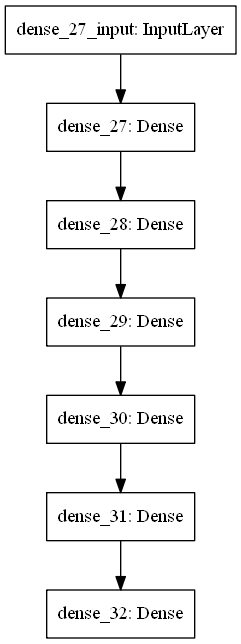

In [63]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [64]:
%%time
model.fit(X_train, y_train, 
          batch_size= 256, 
          epochs = 20, 
          validation_data=(X_test, y_test),
          callbacks=[keras.callbacks.EarlyStopping(patience=15)])

Train on 192000 samples, validate on 48000 samples
Epoch 1/512
192000/192000 [==============================] - 60s 313us/step - loss: 715929.0484 - val_loss: 664835.1663
Epoch 2/512
192000/192000 [==============================] - 59s 308us/step - loss: 661189.3425 - val_loss: 631575.5838
Epoch 3/512
192000/192000 [==============================] - 59s 308us/step - loss: 644319.6019 - val_loss: 640189.3062
Epoch 4/512
192000/192000 [==============================] - 59s 308us/step - loss: 629804.9791 - val_loss: 627839.8376
Epoch 5/512
192000/192000 [==============================] - 63s 327us/step - loss: 624799.5332 - val_loss: 623231.2770
Epoch 6/512
192000/192000 [==============================] - 53s 278us/step - loss: 615122.2919 - val_loss: 615831.7342
Epoch 7/512
192000/192000 [==============================] - 63s 330us/step - loss: 610190.6102 - val_loss: 609829.4081
Epoch 8/512
192000/192000 [==============================] - 74s 384us/step - loss: 604594.8617 - val_loss: 6

KeyboardInterrupt: 

In [65]:
subm_preds = model.predict(val_prep).ravel()
subm = pd.DataFrame({'id':val.id, 'target':subm_preds.ravel()})
subm.to_csv("NN_subm.csv", index=False)

## Random forest

In [106]:
from sklearn.ensemble import RandomForestRegressor

In [107]:
%%time
random_forest = RandomForestRegressor(max_depth=20, n_estimators=1000, min_samples_leaf=20, n_jobs=-1)
random_forest.fit(X_train, y_train)
pred_train = random_forest.predict(X_train)
pred_test = random_forest.predict(X_test)

Wall time: 42min 41s


In [108]:
print("Train "+str(mean_absolute_error(y_train, pred_train)))
print("Test "+str(mean_absolute_error(y_test, pred_test)))

Train 519380.82190427894
Test 618099.7361454667


In [109]:
subm_preds = random_forest.predict(val_prep)
subm = pd.DataFrame({'id':val.id, 'target':subm_preds})
subm.to_csv("Rf_subm.csv", index=False)

# LGBM


In [66]:
import lightgbm as lgb

In [102]:
%%time
lgbm = lgb.LGBMRegressor(max_depth=100,
                        learning_rate=0.03,
                        n_estimators=1000)
lgbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        verbose=False,
        early_stopping_rounds=25)

Wall time: 25 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.03, max_depth=100,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1000, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [103]:
pred_test = lgbm.predict(X_test, num_iteration=lgbm.best_iteration_)
pred_train = lgbm.predict(X_train, num_iteration=lgbm.best_iteration_)

In [104]:
print("Train "+str(mean_absolute_error(y_train, pred_train)))
print("Test "+str(mean_absolute_error(y_test, pred_test)))

Train 553286.0534873547
Test 589477.0477098798


In [105]:
subm_preds = lgbm.predict(val_prep)
subm = pd.DataFrame({'id':val.id, 'target':subm_preds})
subm.to_csv("LGBM_subm.csv", index=False)

# GBR

In [95]:
from sklearn.ensemble import GradientBoostingRegressor

In [96]:
gbr = GradientBoostingRegressor(max_depth=12, n_estimators=500)

In [97]:
%%time
gbr.fit(X_train, y_train)

Wall time: 1h 25min 17s


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=12,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [98]:
gbr_test_pred = gbr.predict(X_test)
gbr_train_pred = gbr.predict(X_train)

In [99]:
mean_absolute_error(y_test,gbr_test_pred)

567722.0232116096

In [100]:
mean_absolute_error(y_train,gbr_train_pred)

121181.29940531179

In [101]:
subm_preds = gbr.predict(val_prep)
subm = pd.DataFrame({'id':val.id, 'target':subm_preds})
subm.to_csv("GBR_subm.csv", index=False)

# Stacking

In [110]:
from sklearn.ensemble import StackingRegressor

In [111]:
estimators = [('xgbr',xgbr),
              ('gbr',gbr),
              ('lgbm',lgbm),
              ('random_forest',random_forest)]

In [112]:
final = xgb.XGBRegressor(learning_rate=0.03,max_depth=4, n_estimators=500, n_jobs=-1, objective ='reg:squarederror')

In [113]:
stacking_reg = StackingRegressor(estimators=estimators, final_estimator=final )

In [ ]:
%%time
stacking_reg.fit(X_train, y_train)

In [ ]:
s_test_pred = stacking_reg.predict(X_test)
s_train_pred = stacking_reg.predict(X_train)

In [ ]:
mean_absolute_error(y_test,rf_test_pred)

In [ ]:
mean_absolute_error(y_train,rf_train_pred)

In [ ]:
subm_preds = stacking_reg.predict(val_prep)
subm = pd.DataFrame({'id':val.id, 'target':subm_preds})
subm.to_csv("Stacking_subm.csv", index=False)